In [75]:
import pandas as pd
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

In [76]:
class PlantDatasetWithFertilizer(Dataset):
    def __init__(self, image_folder_dataset, fertilizer_data):
        self.image_folder_dataset = image_folder_dataset
        self.fertilizer_data = fertilizer_data
        self.fertilizer_mapping = {name: idx for idx, name in enumerate(self.fertilizer_data['Fertilizer Name'].unique())}
    def __len__(self):
        return len(self.image_folder_dataset)
    def __getitem__(self, idx):
        image, disease_label = self.image_folder_dataset[idx]
        fertilizer_name = self.fertilizer_data.iloc[random.randint(0, len(self.fertilizer_data) - 1)]['Fertilizer Name']
        fertilizer_label = self.fertilizer_mapping[fertilizer_name]
        return image, (torch.tensor(disease_label), torch.tensor(fertilizer_label))  # Ensure both are tensors

In [77]:
class CNN(nn.Module):
    def __init__(self, num_disease_classes, num_fertilizer_classes, npk_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        self.disease_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(128 * 28 * 28, 1024),  
            nn.ReLU(),
            nn.Linear(1024, num_disease_classes),
        )
        self.fertilizer_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(128 * 28 * 28, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_fertilizer_classes),
        )
        self.npk_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(128 * 28 * 28, 1024),
                nn.ReLU(),
                nn.Linear(1024, npk_classes)
            ) for _ in range(3)  
        ])
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)  

        disease_output = self.disease_layers(out)
        fertilizer_output = self.fertilizer_layers(out)
        npk_outputs = [layer(out) for layer in self.npk_layers]  
        return disease_output, fertilizer_output, npk_outputs




In [78]:
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


dataset = datasets.ImageFolder('Dataset', transform=transform)


fertilizer_data = pd.read_csv('fertilizer_info.csv')


dataset_with_fertilizer = PlantDatasetWithFertilizer(dataset, fertilizer_data)


In [79]:

indices = list(range(len(dataset_with_fertilizer)))
np.random.shuffle(indices)

split = int(np.floor(0.85 * len(dataset_with_fertilizer)))
train_indices = indices[:split]
validation_indices = indices[split:]

train_loader = DataLoader(dataset_with_fertilizer, batch_size=1000, sampler=SubsetRandomSampler(train_indices))
validation_loader = DataLoader(dataset_with_fertilizer, batch_size=1000, sampler=SubsetRandomSampler(validation_indices))


In [80]:

npk_classes = 3


num_disease_classes = len(dataset.class_to_idx)
num_fertilizer_classes = len(fertilizer_data['Fertilizer Name'].unique())

model = CNN(num_disease_classes, num_fertilizer_classes, npk_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [82]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs, device):
    train_losses = []
    validation_losses = []

    for epoch in range(epochs):
        model.train()  
        running_loss = 0.0

        print(f"Epoch [{epoch + 1}/{epochs}] started.")

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            disease_targets, fertilizer_targets = targets  

            inputs = inputs.to(device)
            disease_targets = disease_targets.to(device)
            fertilizer_targets = fertilizer_targets.to(device)

            optimizer.zero_grad()  # Reset gradients

            disease_output, fertilizer_output, npk_outputs = model(inputs)

            disease_loss = criterion(disease_output, disease_targets)
            fertilizer_loss = criterion(fertilizer_output, fertilizer_targets)

            npk_losses = [
                criterion(npk_outputs[i], torch.randint(0, 3, (inputs.size(0),), device=device))
                for i in range(3)
            ]

            total_loss = disease_loss + fertilizer_loss + sum(npk_losses)
            total_loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += total_loss.item()  # Accumulate batch loss

            print(f"Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {total_loss.item():.4f}")

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch [{epoch + 1}/{epochs}] completed. Average Training Loss: {avg_train_loss:.4f}")

        model.eval()  # Set model to evaluation mode
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                disease_targets, fertilizer_targets = targets

                # Move data to the device
                inputs = inputs.to(device)
                disease_targets = disease_targets.to(device)
                fertilizer_targets = fertilizer_targets.to(device)

                # Forward pass
                disease_output, fertilizer_output, npk_outputs = model(inputs)

                # Compute validation losses
                disease_loss = criterion(disease_output, disease_targets)
                fertilizer_loss = criterion(fertilizer_output, fertilizer_targets)

                npk_losses = [
                    criterion(npk_outputs[i], torch.randint(0, 3, (inputs.size(0),), device=device))
                    for i in range(3)
                ]

                # Accumulate validation loss
                total_loss = disease_loss + fertilizer_loss + sum(npk_losses)
                validation_loss += total_loss.item()

        # Calculate and store average validation loss for the epoch
        avg_validation_loss = validation_loss / len(validation_loader)
        validation_losses.append(avg_validation_loss)
        print(f"Validation Loss after Epoch [{epoch + 1}/{epochs}]: {avg_validation_loss:.4f}\n")

    return train_losses, validation_losses







In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, epochs=5, device=device
)


Epoch [1/5] started.
Epoch [1/5], Batch [1/53], Loss: 9.2266
Epoch [1/5], Batch [2/53], Loss: 675.0223
Epoch [1/5], Batch [3/53], Loss: 568.7872
Epoch [1/5], Batch [4/53], Loss: 258.5389
Epoch [1/5], Batch [5/53], Loss: 97.7883
Epoch [1/5], Batch [6/53], Loss: 60.5621
Epoch [1/5], Batch [7/53], Loss: 45.9247
Epoch [1/5], Batch [8/53], Loss: 38.2366
Epoch [1/5], Batch [9/53], Loss: 34.0309
Epoch [1/5], Batch [10/53], Loss: 26.7845
Epoch [1/5], Batch [11/53], Loss: 21.7743
Epoch [1/5], Batch [12/53], Loss: 19.0439
Epoch [1/5], Batch [13/53], Loss: 16.3357
Epoch [1/5], Batch [14/53], Loss: 14.3085
Epoch [1/5], Batch [15/53], Loss: 14.0682
Epoch [1/5], Batch [16/53], Loss: 11.8428
Epoch [1/5], Batch [17/53], Loss: 12.3161
Epoch [1/5], Batch [18/53], Loss: 11.4673
Epoch [1/5], Batch [19/53], Loss: 9.9125
Epoch [1/5], Batch [20/53], Loss: 9.5221
Epoch [1/5], Batch [21/53], Loss: 10.4162
Epoch [1/5], Batch [22/53], Loss: 9.5835
Epoch [1/5], Batch [23/53], Loss: 9.3071
Epoch [1/5], Batch [24/5

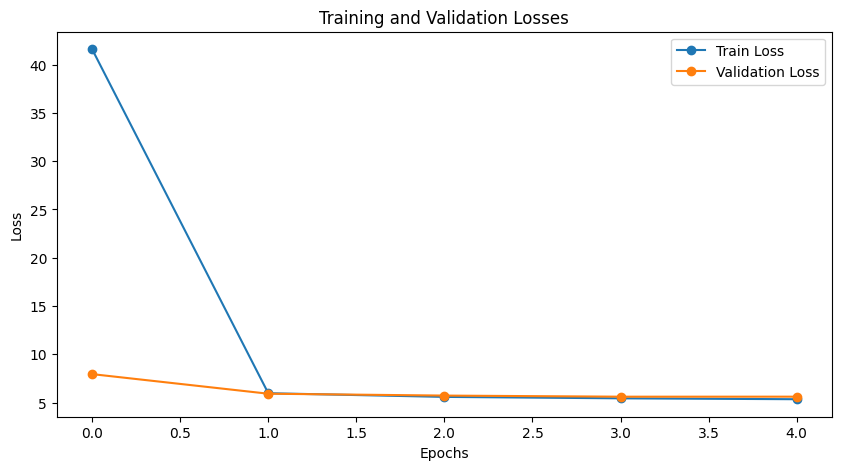

In [84]:
# Section 9: Save Model and Plot Losses
torch.save(model.state_dict(), 'plant_disease_fertilizer_model.pt')

plt.figure(figsize=(10, 5))  # Ensure the figure size is large enough
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(validation_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [91]:
def single_prediction(image_path, model, device):
    # Load the image and apply transformations
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Perform the forward pass
        disease_output, fertilizer_output, npk_outputs = model(input_tensor)

    # Get predictions
    disease_prediction = torch.argmax(disease_output, dim=1).item()
    fertilizer_prediction = torch.argmax(fertilizer_output, dim=1).item()

    # N, P, and K predictions (e.g., class indices or continuous values)
    n_pred = torch.argmax(npk_outputs[0], dim=1).item()
    p_pred = torch.argmax(npk_outputs[1], dim=1).item()
    k_pred = torch.argmax(npk_outputs[2], dim=1).item()

    # Map predictions back to class names (if needed)
    disease_class = list(dataset.class_to_idx.keys())[disease_prediction]
    fertilizer_class = fertilizer_data['Fertilizer Name'].unique()[fertilizer_prediction]

    print(f"Predicted Disease: {disease_class}")
    print(f"Predicted Fertilizer: {fertilizer_class}")
    print(f"Predicted Nitrogen Level: {n_pred}")
    print(f"Predicted Phosphorus Level: {p_pred}")
    print(f"Predicted Potassium Level: {k_pred}")

    return disease_class, fertilizer_class, n_pred, p_pred, k_pred

# Example Usage
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the trained model weights
model.load_state_dict(torch.load('plant_disease_fertilizer_model.pt', map_location=device))
model.to(device)

# Perform a single prediction
image_path = 'apple_black_rot.jpg'  # Replace with your test image path
predicted_disease, predicted_fertilizer, n, p, k = single_prediction(image_path, model, device)







/var/folders/3j/7f0xfyh52sj947j5n_g79l2m0000gp/T/ipykernel_43115/611770151.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('plant_disea

Predicted Disease: Apple___Black_rot
Predicted Fertilizer: Urea
Predicted Nitrogen Level: 0
Predicted Phosphorus Level: 2
Predicted Potassium Level: 0


In [90]:
image_path = 'apple_black_rot.jpg'  # Replace with the path to your test image
predicted_disease, predicted_fertilizer = single_prediction(image_path)
print(predicted_disease, predicted_fertilizer)

TypeError: single_prediction() missing 2 required positional arguments: 'model' and 'device'

In [89]:


from sklearn.metrics import classification_report

def print_classification_reports(model, validation_loader, device):
    model.eval()  # Set the model to evaluation mode

    all_disease_preds = []
    all_fertilizer_preds = []
    all_disease_targets = []
    all_fertilizer_targets = []

    with torch.no_grad():  # No gradient calculation in evaluation
        for inputs, targets in validation_loader:
            disease_targets, fertilizer_targets = targets  # Unpack targets

            # Move data to the correct device
            inputs = inputs.to(device)
            disease_targets = disease_targets.to(device)
            fertilizer_targets = fertilizer_targets.to(device)

            # Forward pass
            disease_output, fertilizer_output, _ = model(inputs)

            # Get predictions
            disease_preds = torch.argmax(disease_output, dim=1)
            fertilizer_preds = torch.argmax(fertilizer_output, dim=1)

            # Collect all predictions and targets
            all_disease_preds.extend(disease_preds.cpu().numpy())
            all_fertilizer_preds.extend(fertilizer_preds.cpu().numpy())
            all_disease_targets.extend(disease_targets.cpu().numpy())
            all_fertilizer_targets.extend(fertilizer_targets.cpu().numpy())

    # Print classification reports for disease and fertilizer predictions
    print("Classification Report for Disease Prediction:")
    print(classification_report(all_disease_targets, all_disease_preds))

    print("\nClassification Report for Fertilizer Prediction:")
    print(classification_report(all_fertilizer_targets, all_fertilizer_preds))



print_classification_reports(model, validation_loader, device)


Classification Report for Disease Prediction:
              precision    recall  f1-score   support

           0       0.82      0.46      0.59       149
           1       0.87      0.73      0.80       135
           2       0.76      0.86      0.81       148
           3       0.85      0.83      0.84       222
           4       0.97      0.93      0.95       175
           5       0.93      0.94      0.94       215
           6       0.87      0.83      0.85       157
           7       0.77      0.91      0.84       154
           8       0.67      0.77      0.72       150
           9       0.97      0.99      0.98       182
          10       0.83      0.65      0.73       132
          11       0.93      0.96      0.95       178
          12       0.83      0.89      0.86       169
          13       0.95      0.86      0.90       212
          14       0.91      0.96      0.93       163
          15       0.92      0.83      0.87       149
          16       0.97      0.97  

/Users/devashishmudigonda/Desktop/TRANSFER DEV/Plant-Disease-Prediction-main/Plant-Disease-Prediction-main/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/devashishmudigonda/Desktop/TRANSFER DEV/Plant-Disease-Prediction-main/Plant-Disease-Prediction-main/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/devashishmudigonda/Desktop/TRANSFER DEV/Plant-Disease-Prediction-main/Plant-Disease-Prediction-main/venv/lib/python3.12/site-packages/sklearn/metrics/_classi